In [347]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [368]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery("div.input").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('div.input').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


In [349]:
# nice, interactive plotting.
%matplotlib notebook

In [350]:
# if KSPDIR is set, load the telemetry file from the game directory. Otherwise, load from current directory
if "KSPDIR" in os.environ:
    telemetry_file = os.path.join(os.environ["KSPDIR"], r"GameData\Telemetry\Trajectories.csv")
else:
    telemetry_file = "Trajectories.csv"

In [351]:
data = pd.read_csv(telemetry_file, sep='\t')
data.fillna(method="ffill", inplace=True) # fill everything we can with the previous value

In [352]:
# shift time axis to start with 0
data["ut"] -= data["ut"][0]

In [353]:
data.set_index("ut", inplace=True)

In [354]:
# show all channels for a summary
data.plot(subplots=True, title="Telemetry");

<IPython.core.display.Javascript object>

In [355]:
# trim data
# We want the data in the atmosphere, so we clip everything where the air temperature is <= 4K and the altitude is too small
d = data[((data["temperature"] > 4) & (data["altitude"] > 1000))]

In [356]:
# Run this for only High-Altitude Data
d = data[data["altitude"].between(50000, 70000)]

## Angle of Attack

<IPython.core.display.Javascript object>


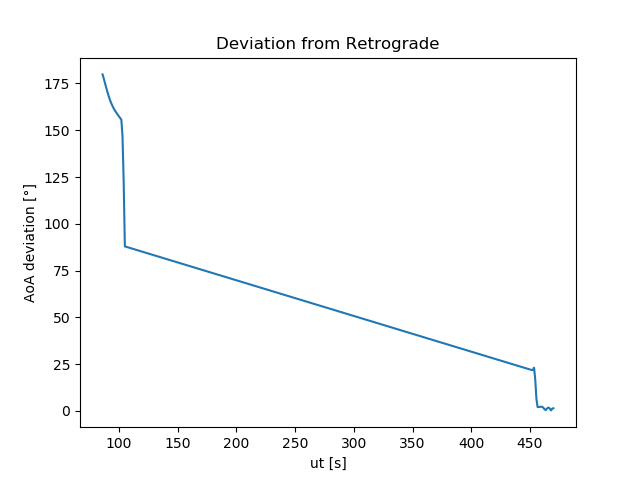

In [357]:
plt.figure();
aoa_dev = 180 - np.abs(d["aoa"])
plt.plot(aoa_dev)
plt.ylabel("AoA deviation [°]")
plt.xlabel("ut [s]")
plt.title("Deviation from Retrograde");
# plt.ylim([0.0, 0.1])
plt.show();

In [358]:
np.min(d["force_actual"])

0.00464514979492104

## Forces

<IPython.core.display.Javascript object>


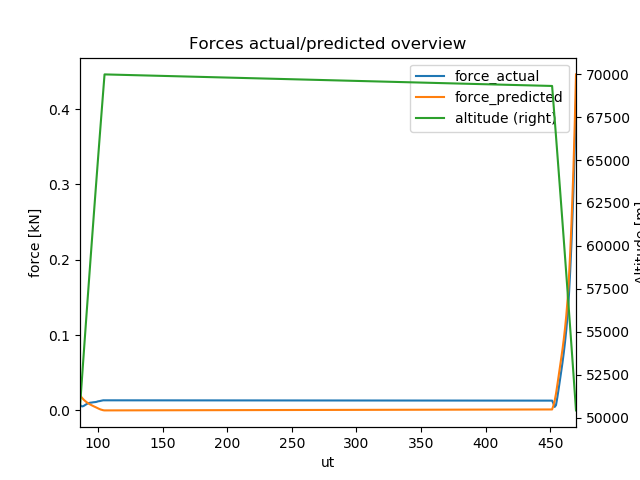

In [359]:
# plt.figure();
ax = (d[["force_actual", "force_predicted"]]).plot()
ax.set_ylabel("force [kN]");
ax = d["altitude"].plot(ax=ax, secondary_y=True, legend=True)
ax.set_ylabel("Altitude [m]")
plt.xlabel("ut [s]")
plt.xlim([d.index[0], d.index[-1]])
plt.title("Forces actual/predicted overview");
plt.show();

<IPython.core.display.Javascript object>


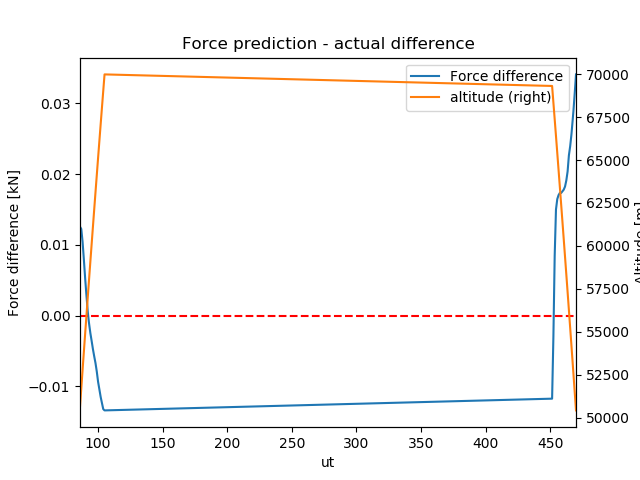

In [360]:
plt.figure();
ax = (d["force_predicted"] - d["force_actual"]).rename("Force difference").plot(legend=True)
ax.set_label("test")
plt.ylabel("Force difference [kN]")
# ax.set_ylim([0.0, 2])
ax.axhline(y=0.0, color='r', linestyle='--')
ax = d["altitude"].plot(ax=ax, secondary_y=True, legend=True)
ax.set_ylabel("Altitude [m]")
plt.xlabel("ut [s]")
plt.xlim([d.index[0], d.index[-1]])
plt.title("Force prediction - actual difference");
plt.show();

In [361]:
plt.figure();
ax = (d["force_predicted"] / d["force_actual"]).rename("Force ratio").plot(legend=True)
plt.ylabel("Force ratio [-]")
# ax.set_ylim([0.0, 2])
ax.axhline(y=1.0, color='r', linestyle='--')
ax = d["altitude"].plot(ax=ax, secondary_y=True, legend=True)
ax.set_ylabel("Altitude [m]")
plt.xlabel("ut [s]")
plt.xlim([d.index[0], d.index[-1]])
plt.title("Force prediction/actual ratio");
plt.show();

<IPython.core.display.Javascript object>

In [362]:
plt.figure();
ax = ((d["force_predicted"] - d["force_actual"])/d["force_actual"]).rename("Rel. Force ratio").plot(legend=True)
ax.set_ylabel("Force difference [-]")
ax.axhline(y=0.0, color='r', linestyle='--')
ax = d["altitude"].plot(ax=ax, secondary_y=True, legend=True)
ax.set_ylabel("Altitude [m]")
plt.xlabel("ut [s]")
plt.xlim([d.index[0], d.index[-1]])
plt.title("Relative force difference between predicted and actual");
plt.show();

<IPython.core.display.Javascript object>

In [363]:
if set(["force_predicted.x", "force_predicted.y", "force_predicted.z", "force_actual.x", "force_actual.y", "force_actual.z"]).issubset(data.columns):
    predicted_force = d[["force_predicted.x", "force_predicted.y", "force_predicted.z"]].values
    actual_force = d[["force_predicted.x", "force_predicted.y", "force_predicted.z"]].values
    angles_rad = np.arccos(np.clip(np.matmul(predicted_force, actual_force.T).diagonal() / (np.linalg.norm(predicted_force, axis=1) * np.linalg.norm(actual_force, axis=1)), -1, 1))
    
    plt.figure();
    plt.plot(d.index.values, angles_rad*180/np.pi)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel("ut [s]")
    plt.ylabel("Angle between forces[°]")
    plt.xlim([d.index[0], d.index[-1]])
    plt.title("Angle between predicted and actual forces");
    plt.show();

<IPython.core.display.Javascript object>

In [364]:
# Average angle between predicted and actual
np.mean(angles_rad) * 180/np.pi

3.3899808056706556e-07

# Density

In [365]:
plt.figure();
ax = ((d["density_calc"] - d["density"])/d["density"] * 100).rename("Relative density difference").plot(legend=True)
ax.set_ylabel("density difference [%]")
ax.axhline(y=0.0, color='r', linestyle='--')
ax = d["altitude"].plot(ax=ax, secondary_y=True, legend=True)
ax.set_ylabel("Altitude [m]")
plt.xlabel("ut [s]")
plt.xlim([d.index[0], d.index[-1]])
plt.title("Relative density difference between predicted and actual");
plt.show();

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


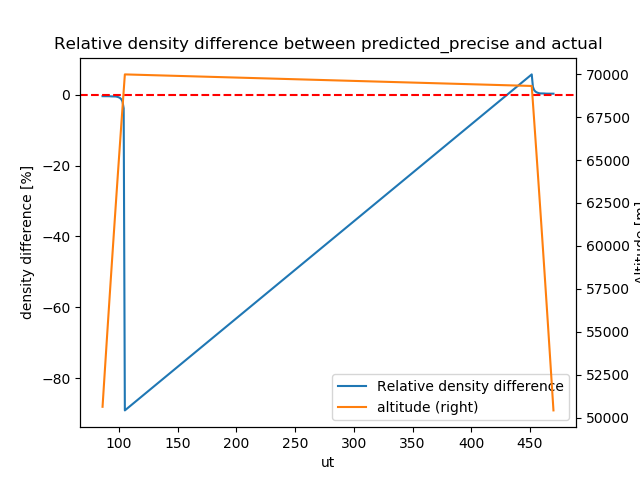

In [366]:
plt.figure();
ax = ((d["density_calc_precise"] - d["density"])/d["density"] * 100).rename("Relative density difference").plot(legend=True)
ax.set_ylabel("density difference [%]")
ax.axhline(y=0.0, color='r', linestyle='--')
ax = d["altitude"].plot(ax=ax, secondary_y=True, legend=True)
ax.set_ylabel("Altitude [m]")
plt.xlabel("ut [s]")
#plt.xlim([d.index[0], d.index[-1]])
plt.title("Relative density difference between predicted_precise and actual");
plt.show();

<IPython.core.display.Javascript object>


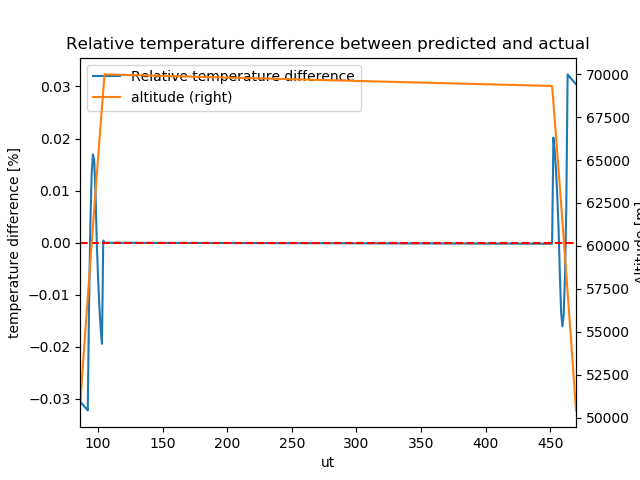

In [367]:
plt.figure();
ax = ((d["temperature_calc"] - d["temperature"])/d["temperature"] * 100).rename("Relative temperature difference").plot(legend=True)
ax.set_ylabel("temperature difference [%]")
ax.axhline(y=0.0, color='r', linestyle='--')
ax = d["altitude"].plot(ax=ax, secondary_y=True, legend=True)
ax.set_ylabel("Altitude [m]")
plt.xlabel("ut [s]")
plt.xlim([d.index[0], d.index[-1]])
plt.title("Relative temperature difference between predicted and actual");
plt.show();